<a href="https://colab.research.google.com/github/jackliu333/object_detection_using_tensorflow/blob/main/Training_Customised_Image_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes

https://planspace.org/20170323-tfrecords_for_humans/

https://github.com/tensorflow/models/tree/master/research/object_detection
    
https://medium.com/practical-deep-learning/a-complete-transfer-learning-toolchain-for-semantic-segmentation-3892d722b604

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/

In [1]:
# Codes adapted from https://github.com/nicknochnack/TFODCourse/blob/main/2.%20Training%20and%20Detection.ipynb
# Images sampled from https://github.com/marcusklasson/GroceryStoreDataset, with bounding boxes drawn manually for each object
# To run using Google Colab; switch runtime type to GPU for speedup
import numpy as np
import random
import tensorflow as tf

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration parameters

Including paths and training hyper-parameters

In [2]:
import os
print(f"Current OS: {os.name}") 

Current OS: nt


In [ ]:
# TensorFlow 2 Detection Model Zoo

# Getting other pretrained models
# https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [3]:
#CUSTOM_MODEL_NAME = 'my_ssd_mobnet'

# SSD has good tradeoff between speed and accuracy; can switch to other pretrained model
#PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'


#CUSTOM_MODEL_NAME = 'my_efficientdet_d4'

#PRETRAINED_MODEL_NAME = 'efficientdet_d4_coco17_tpu-32'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz'


CUSTOM_MODEL_NAME = 'my_efficientdet_d0'

PRETRAINED_MODEL_NAME = 'efficientdet_d0_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz'


# TF official script to encode training data to tf record format
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

# Mapping dictionary between label and integer id
LABEL_MAP_NAME = 'label_map.pbtxt'

TENSORFLOW = '..'

# Define a list of folder paths to be created (if needed) and used later
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    #'IMAGE_SOURCE_PATH':os.path.join('images'),
    'IMAGE_SOURCE_PATH': os.path.join('E:', os.sep,'Users','Vince','Datasets','NZRC','Gordon','CycloneGitaRawImagery','ML4DR_20210910_01','tiles'),
    
    #'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'ANNOTATION_PATH': os.path.join('E:', os.sep,'Users','Vince','Datasets','NZRC','Gordon','CycloneGitaRawImagery','ML4DR_20210910_01','tiles'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'PROTOC_PATH': os.path.join('Tensorflow','protoc')
}

files = {
    'PIPELINE_CONFIG': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# create folder paths if not exist
for p in paths.values():
    if not os.path.exists(p):
        !mkdir -p {p}
        print(p)

## Utilities

Image plot

In [4]:
# Plot an image from a TF Record with its bounding boxes and labels

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plt_image_with_labels(image, annotations, categories):
    ## Display the image, with bboxes and labels
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(7, 7))

    # Display the image
    ax.imshow(image)
    height = annotations["image/height"]
    width = annotations["image/width"]
    # Create Rectangle patches, i.e. bbox add rectangles to the image
    for j in range(len(annotations['image/object/class/label'])):
        x1 = annotations["image/object/bbox/xmin"][j] * width
        y1 = annotations["image/object/bbox/ymin"][j] * height
        x2 = annotations["image/object/bbox/xmax"][j] * width - x1
        y2 = annotations["image/object/bbox/ymax"][j] * height - y1
        
        category_num = annotations["image/object/class/label"][j]-1
        label = categories[category_num]["name"]
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='red', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(x1,y1, label, horizontalalignment='left', fontsize=8, color='red')

    plt.show()

In [5]:
# Plot an image from a TF Record with its bounding boxes and labels

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plt_image_with_labels2(image, annotations, categories):
    ## Display the image, with bboxes and labels
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(7, 7))

    # Display the image
    ax.imshow(image)
    height = annotations['height']
    width = annotations['width']
    # Create Rectangle patches, i.e. bbox add rectangles to the image
    for row in annotations['annotations']:
        x1, y1, x2, y2 = row['bbox']
        
        category_num = row['category_id']-1
        label = categories[category_num]["name"]
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='red', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(x1,y1, label, horizontalalignment='left', fontsize=8, color='red')

    plt.show()

Create lable map

In [6]:
def create_label_map(lables, path=files['LABELMAP']):
    with open(files['LABELMAP'], 'w') as f:
        for label in labels:
            f.write('item { \n')
            f.write('\tname:\'{}\'\n'.format(label['name']))
            f.write('\tid:{}\n'.format(label['id']))
            f.write('}\n')

# Set up TF model training logistics

### Download TF model training utility scripts from TF model zoo

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'objection_detection')):
    !git clone https://github.com/tensorflow/`models {paths['APIMODEL_PATH']}

### Install TF object detection library

May hit some error during installation, can be ignored, as long as it returns "OK" in the last line.

In [ ]:
#Linux version
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. 
    !cd Tensorflow/models/research && cp object_detection/packages/tf2/setup.py . && python -m pip install . 


#windows version
if os.name =='nt':
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=.
    !cd Tensorflow/models/research && copy object_detection\packages\tf2\setup.py . && python -m pip install .

In [ ]:
# Verify installation
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

In [7]:
# test if TF object detection library could be loaded
import object_detection

### Download and decompress TF pretrained model

In [ ]:
#linux version
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

#Windows version
if os.name =='nt':
    !wget {PRETRAINED_MODEL_URL}
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

### Create label map

In [8]:
#labels = [{'name':'Apple', 'id':1},
#          {'name':'Avocado', 'id':2},
#          {'name':'Banana', 'id':3},
#          {'name':'Cabbage', 'id':4},
#          {'name':'Carrot', 'id':5},
#          {'name':'Potato', 'id':6}]

labels = [{'name':'None', 'id':1},
          {'name':'<25%', 'id':2},
          {'name':'>25%', 'id':3},
          {'name':'Abandoned', 'id':4},
          {'name':'Other', 'id':5}]

create_label_map(labels, files['LABELMAP'])

### Download training images

In [ ]:
#Not needed
#import shutil

#if os.path.exists('object_detection_using_tensorflow'):
#    shutil.rmtree('object_detection_using_tensorflow')

#!git clone https://github.com/jackliu333/object_detection_using_tensorflow.git

### Split into train test folders

Don't use this for COCO data

In [ ]:
#Create image destination folders
import shutil

tmp_folders = ['train', 'test']

#windows version
if os.name =='nt':
    for i in tmp_folders:
        if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
            shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
            !mkdir {os.path.join(paths['IMAGE_PATH'], i)}
        else:
            !mkdir {os.path.join(paths['IMAGE_PATH'], i)}
#Linux
if os.name =='posix':
    for i in tmp_folders:
        if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
            shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
            !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}
        else:
            !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}

In [ ]:
#Copy images from source folders to destination folders
# Create a list of image file paths from "image_source_path + label name"
# This assume the images are stored in folders with the category (class) name
import shutil

for i in range(len(labels)):
    from_path = os.path.join(paths['IMAGE_SOURCE_PATH'],labels[i]['name'])

    # get unique file names
    tmp_files = os.listdir(from_path)
    tmp_names = []
    tmp_file_types = []
    for tmp_file in tmp_files:
        tmp_name = os.path.splitext(tmp_file)[0]
        tmp_file_type = os.path.splitext(tmp_file)[1]
        tmp_names.append(tmp_name)
        tmp_file_types.append(tmp_file_type)
    tmp_names = list(set(tmp_names))
    tmp_names = [i for i in tmp_names if i != '.DS_Store']
    tmp_file_types = list(set(tmp_file_types))
    tmp_file_types = [i for i in tmp_file_types if len(i) != 0]
    # random shuffle the files
    random.shuffle(tmp_names)
    
    # training and test files
    tmp_names_train = tmp_names[0:int(len(tmp_names)*0.9)]
    tmp_names_test = [i for i in tmp_names if i not in tmp_names_train]

    # move into respective target folders
    for tmp_name in tmp_names_train:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "train"))

    for tmp_name in tmp_names_test:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "test"))

### Create TF Record from COCO files

In [9]:
root_dir = os.path.join('E:', os.sep ,'Users', 'Vince', 'Datasets', 'NZRC', 'Gordon', 'CycloneGitaRawImagery', 'ML4DR_20210910_01')
tfrecords_dir = os.path.join(root_dir, 'tfrecords/train')
images_dir = os.path.join(root_dir, 'tiles')
annotations_dir = os.path.join(root_dir, 'tiles')
#annotation_file = os.path.join(annotations_dir, "ML4DR_20210910_01_coco.json")
annotation_file = os.path.join(annotations_dir, 'ML4DR_20210910_01_coco_tiled.json')
paths['IMAGE_PATH'] = images_dir


In [ ]:
paths['IMAGE_PATH']

In [10]:
#Load COCO file information

import json

#Load image refs from COCO file
with open(annotation_file, "r") as f:
    coco_images = json.load(f)["images"]

#Load annotations from COCO file
with open(annotation_file, "r") as f:
    coco_annotations = json.load(f)["annotations"]
    
#Load categories from COCO file
with open(annotation_file, "r") as f:
    coco_categories = json.load(f)["categories"]

In [11]:
#Rearrange COCO file info into a form that can be used to create the TF Record file
# this requires the annotation info for each image be associated to the image info
# and it requires a category dictionary to convert from category_id to category_text

#Work through coco-images
# Extract the image attributes
# For each image get a list of annotations
# Add the annotations list to the image

imageInfoList = []
for image_info in coco_images:
    annotationsList = []
    for annotation in coco_annotations:
        if image_info['id'] == annotation['image_id']:
            annotationsList.append(annotation)
    if len(annotationsList)>0:
        image = image_info
        image['annotations'] = annotationsList
        imageInfoList.append(image)
        
categories = {}
labels = []
for cat in coco_categories:
    labels.append({'name':cat['name'], 'id':cat['id']})
    categories[cat['id']] = cat['name']
    
create_label_map(labels, files['LABELMAP'])

In [12]:
#This is used when creating the TF Record files
# in the TF Record file
# Store each image with its annotations

from object_detection.utils import dataset_util #, label_map_util
import io
from PIL import Image

def create_tf_example(imageInfo, image_path):
    with tf.io.gfile.GFile(os.path.join(image_path, '{}'.format(imageInfo['file_name'])), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)

    image_id = imageInfo['id']
    image_width  = int(imageInfo['width'])
    image_height = int(imageInfo['height'])

    filename = imageInfo['file_name']
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    category_names = []
    category_ids = []
    num_annotations_skipped = 0
    for row in imageInfo['annotations']:
        (x, y, width, height) = tuple(row['bbox'])
        if x + width > image_width or y + height > image_height:
            num_annotations_skipped += 1
            continue
        xmins.append(x / image_width)
        xmaxs.append((x + width) / image_width)
        ymins.append(y / image_height)
        ymaxs.append((y + height) / image_height)
        category_id = int(row['category_id'])
        category_names.append(categories[category_id].encode('utf8'))
        category_ids.append(category_id)

    feature = {
        'image/height': dataset_util.int64_feature(image_height),
        'image/width': dataset_util.int64_feature(image_width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(str(image_id).encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(category_names), #?????
        'image/object/class/label': dataset_util.int64_list_feature(category_ids),
    }
    tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
    return tf_example


#This is used read the TF Records
#<https://www.tensorflow.org/api_docs/python/tf/io/FixedLenSequenceFeature>
def parse_tfrecord_fn(example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True, default_value=None),
        'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True, default_value=None),
        'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True, default_value=None),
        'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True, default_value=None),
        'image/object/class/text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True, default_value=None),
        'image/object/class/label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True, default_value=None),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example

In [ ]:
# Create TF Record files
output_path = os.path.join(paths['ANNOTATION_PATH'],'test.record')
writer = tf.io.TFRecordWriter(output_path)

for imageInfo in imageInfoList:
    tf_example = create_tf_example(imageInfo, paths['IMAGE_SOURCE_PATH'])
    writer.write(tf_example.SerializeToString())


output_path = os.path.join(paths['ANNOTATION_PATH'],'train.record')
writer = tf.io.TFRecordWriter(output_path)

for imageInfo in imageInfoList:
    tf_example = create_tf_example(imageInfo, paths['IMAGE_SOURCE_PATH'])
    writer.write(tf_example.SerializeToString())


In [ ]:
os.path.join(paths['ANNOTATION_PATH'],'train.record')

In [ ]:
#Read TFRecord files and Plot an image with the label boxes

import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

raw_dataset = tf.data.TFRecordDataset(os.path.join(paths['ANNOTATION_PATH'], 'train.record'))
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

sample = parsed_dataset.take(2)
#sample = random.choice([file for file in os.listdir(os.path.join(paths['IMAGE_PATH'], '')) if file.endswith(".JPG")])

for item in sample.as_numpy_iterator():
    encoded_jpg = item['image/encoded']
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    image_np = np.array(image)
    plt_image_with_labels(image_np, item, coco_categories)


### Copy model configuration file to training folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}
    
if os.name =='nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}

### Update configuration file for transfer learning

In [ ]:
print('PRETRAINED_MODEL_NAME =', PRETRAINED_MODEL_NAME)
print('pipeline_config.train_config.fine_tune_checkpoint =')
print('     ' , os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0'))
print('MODEL_PATH =', paths['MODEL_PATH'])
print()
print('python ', TRAINING_SCRIPT)
print('   --model_dir={} ', paths['CHECKPOINT_PATH'])
print('   --pipeline_config_path={} ', files['PIPELINE_CONFIG'])

In [148]:
# Use this to load an partially fine tuned model ????????
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Read current configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

# Update based on new labels
pipeline_config.model.ssd.num_classes = len(labels)
#pipeline_config.train_config.batch_size = 4
#pipeline_config.train_config.batch_size = 3
pipeline_config.train_config.batch_size = 2

#if the batch size is small the learning rate needs to be reduced for the model to converge
#https://github.com/tensorflow/models/issues/9151
#https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.001 #0.08
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 0.001 #0.001
#pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint1', 'ckpt-3')
#pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint2', 'ckpt-3')
#pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint3', 'ckpt-3')
#pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint4', 'ckpt-3')
#pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint5', 'ckpt-3')
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint6', 'ckpt-3')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
pipeline_config.eval_input_reader[0].num_epochs = 1

# Write to configuration file
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [16]:
#Use this for pretraind model from the pretrained model folder (downloaded from model zoo)
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Read current configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

# Update based on new labels
pipeline_config.model.ssd.num_classes = len(labels)
#pipeline_config.train_config.batch_size = 4
#pipeline_config.train_config.batch_size = 3
pipeline_config.train_config.batch_size = 2
#pipeline_config.train_config.batch_size = 1

#if the batch size is small the learning rate needs to be reduced for the model to converge
#https://github.com/tensorflow/models/issues/9151
#https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
pipeline_config.train_config.optimizer.momentium_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.02 #0.08
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
pipeline_config.eval_input_reader[0].num_epochs = 1

# Write to configuration file
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

# Model training

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30

In [ ]:
# fix opencv-python version issue 
#!pip uninstall opencv-python-headless 
#!pip install opencv-python-headless==4.1.2.30

In [150]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
!{command}

2023-02-04 15:54:32.428075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 15:54:32.973415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1347 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0204 15:54:33.201376  9788 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0204 15:54:33.206374  9788 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:May

In [ ]:
#Training details

#   https://www.tensorflow.org/guide/distributed_training
#   https://www.tensorflow.org/guide/checkpoint

#model_main_tf2.py
#main()
#   model_lib_v2.train_loop()

#model_lib_v2.py
#   training_loop()
#      train_step_fn()
#         eager_train_step()
#            _compute_losses_and_predictions_dicts()

# (Optional) Model evaluation

In [ ]:
# stop evaluation if needed
#command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
#!{command}

# Predicting object category in image

### Load trained model from checkpoint

In [151]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
#ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'checkpoint1', 'ckpt-2')).expect_partial()
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

# @tf.function
def detect_fn(image):
    print(image.shape)
    image, shapes = detection_model.preprocess(image)
    print(image.shape, shapes.shape)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### Detect objects in image

(1, 1000, 1000, 3)
(1, 512, 512, 3) (1, 3)


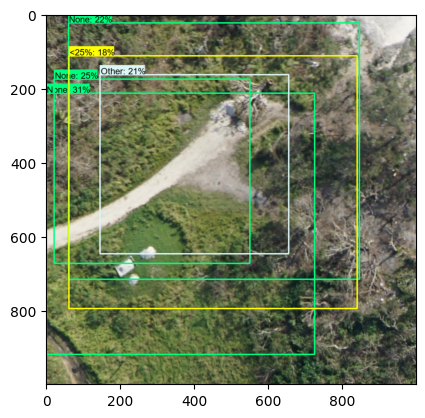

In [155]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline

# Randomly select an image to be detected
test_path = os.path.join(paths['IMAGE_PATH'])
tmp_img = random.choice([file for file in os.listdir(test_path) if file.endswith(".JPG")])
IMAGE_PATH = os.path.join(test_path, tmp_img)

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.05, #(0.5)
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [146]:
detections['detection_scores']

array([0.8351134 , 0.7474723 , 0.7058187 , 0.634718  , 0.6258721 ,
       0.5570957 , 0.5535938 , 0.5288791 , 0.4777413 , 0.42742914,
       0.40722752, 0.39184886, 0.39176616, 0.37241971, 0.3348875 ,
       0.33201918, 0.3256017 , 0.31330228, 0.31201717, 0.3072222 ,
       0.29754648, 0.2975276 , 0.29297835, 0.28764614, 0.28572497,
       0.27992627, 0.27318224, 0.27297917, 0.26285112, 0.25949043,
       0.25006428, 0.24803875, 0.23946917, 0.23436823, 0.23283279,
       0.23245847, 0.23131819, 0.2250691 , 0.22462009, 0.22089703,
       0.20433241, 0.20221111, 0.20160344, 0.19844845, 0.19735377,
       0.19138229, 0.1910306 , 0.18453634, 0.18270382, 0.18139288,
       0.17819388, 0.17311701, 0.17184193, 0.16867517, 0.16721329,
       0.1646163 , 0.1635916 , 0.16342314, 0.16177066, 0.15889253,
       0.15794165, 0.15312289, 0.15236972, 0.1518422 , 0.1503118 ,
       0.14818518, 0.1471256 , 0.14650618, 0.14596933, 0.1442961 ,
       0.14206566, 0.14101395, 0.14065847, 0.14009583, 0.13843

In [47]:
detections['detection_boxes']

array([], shape=(0, 4), dtype=float32)

In [ ]:
x, y, c = image_np.shape
print(x,y,c)

In [ ]:
print(detections['detection_boxes'][0:6]*[x,y,x,y])

In [ ]:
print(detections['detection_scores'][0:6])

In [ ]:
print(category_index)

In [ ]:
print(len(detections))
print(list(detections))

In [ ]:
print(detections['detection_classes']+1)

In [ ]:
print(num_detections)
print(len(detections['detection_scores']))
print(len(detections['detection_boxes']))

In [ ]:
os.path.join(paths['IMAGE_PATH'])